In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, flatten
from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, Module, Dropout, ReLU
import torch.nn.functional as F
import random
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ])

trainset = datasets.MNIST('./', download=True, train=True,  transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)
print(trainset.data.size())

torch.Size([60000, 28, 28])


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1,16, kernel_size=3,stride=1,padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(16,32, kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(32*7*7,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,14)
        self.fc4 = nn.Linear(14,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x) 
        #flatten
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)      
        return x

In [5]:
def train(model, lr, epoch, batch_size):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    #print(len(trainloader))
    #print(len(trainset))
    model.to(device)
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr)
    trainLoss = []
    trainAcc = []
    step = 0
    for e in range(epoch):
        model.train()
        train_loss = 0
        trainacc=0
        for images, labels in trainloader:
            step+=1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model(images) #forward propagation
            loss = loss_fn(logps, labels) #calculate loss
            train_loss+=loss.item()
            
            _, pred = logps.max(1)
            #print(pred, labels)
            trainacc += (pred == labels).sum()
            
            loss.backward() #backward propagation
            optimizer.step() #update weights
            
        tloss = train_loss/len(trainloader)
        acc = trainacc/len(trainset)
        trainLoss.append(tloss)
        trainAcc.append(acc)
        print("Epoch: {}  Train Loss: {:.4f}  Train Accuracy {:.2f}".format(e+1, tloss, trainacc/len(trainset)))
            
    return trainLoss, trainAcc, model



def validate(model):
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
    loss_fn = nn.NLLLoss()
    testLoss = []
    testAcc = []
    with torch.no_grad():
        valloss = 0
        acc = 0
        model.eval()
        for img, label in testloader:
            img, label = img.to(device), label.to(device)
            logps = model(img) #forward propagation
            loss = loss_fn(logps, label) #calculate loss
            valloss+=loss.item()
            _, pred = logps.max(1)
            acc += (pred == label).sum()
        vloss = valloss/len(testloader)
        vaccr = acc/len(testset)
        testLoss.append(vloss)
        testAcc.append(vaccr)
    return testLoss, testAcc

# Training models with different batch sizes (64, 1024)

In [8]:
epoch = 5
m1_batch64 = CNN()
print("==============Model_1: Batch Size = 64==============")
trainloss1, trainacc1, m1_batch64 = train(m1_batch64, lr=0.001, epoch=epoch, batch_size=64)

m2_batch1024 = CNN()
print("\n==============Model_2: Batch Size = 1024==============")
trainloss2, trainacc2, m2_batch1024 = train(m2_batch1024, lr=0.001, epoch=epoch, batch_size=1024)

==============Model_1: Batch Size = 64==============
Epoch: 1  Train Loss: 0.3622  Train Accuracy 0.88
Epoch: 2  Train Loss: 0.0677  Train Accuracy 0.98
Epoch: 3  Train Loss: 0.0469  Train Accuracy 0.99
Epoch: 4  Train Loss: 0.0354  Train Accuracy 0.99
Epoch: 5  Train Loss: 0.0281  Train Accuracy 0.99

==============Model_2: Batch Size = 1024==============
Epoch: 1  Train Loss: 1.3555  Train Accuracy 0.52
Epoch: 2  Train Loss: 0.4458  Train Accuracy 0.86
Epoch: 3  Train Loss: 0.2637  Train Accuracy 0.92
Epoch: 4  Train Loss: 0.1813  Train Accuracy 0.95
Epoch: 5  Train Loss: 0.1344  Train Accuracy 0.96


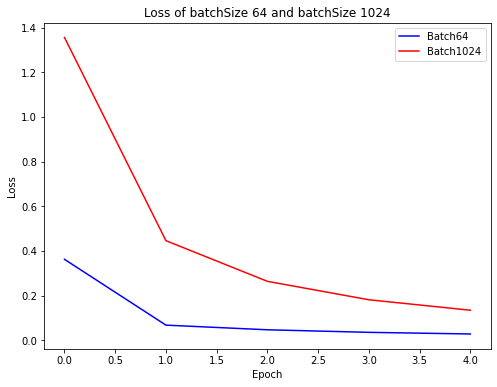

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(epoch), trainloss1, 'b', label='Batch64')
plt.plot(np.arange(epoch), trainloss2, 'r', label='Batch1024')
plt.title("Loss of batchSize 64 and batchSize 1024")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
batch64_params = torch.nn.utils.parameters_to_vector(m1_batch64.parameters())
batch1024_params = torch.nn.utils.parameters_to_vector(m2_batch1024.parameters())

In [ ]:
testparams = (1-alpha_list[i])*batch64_params + alpha_list[i]*batch1024_params
print(testparams[340100:])
test = CNN()
print('old parameter')
#for p in test.parameters():
    #print(p)
print()
print('new parameter')
torch.nn.utils.vector_to_parameters(testparams, test.parameters())
for p in test.parameters():
    d = "j"
print(p)

### Training a new model with interpolated parameters using different alpha values

In [17]:
alpha_list = np.arange(-2,2.2,0.2)
TrainLossList = []
TrainAccList = []
TestLossList = []
TestAccList = []

for i in range(len(alpha_list)):
    print(f'===================Alpha= {alpha_list[i]:.2f}===================')
    new_parameters = (1-alpha_list[i])*batch64_params + alpha_list[i]*batch1024_params
    #print(new_parameters)
    new_model = CNN()
    torch.nn.utils.vector_to_parameters(new_parameters, new_model.parameters())
    trainloss, trainacc, new_model = train(new_model, lr=0.001, epoch=1, batch_size=64)
    TrainAccList.append(trainacc[-1].item())
    TrainLossList.append(min(trainloss))
    #print(trainloss)
    
    #test model
    testloss, testacc = validate(new_model)
    TestLossList.append(testloss[0])
    TestAccList.append(testacc[0].item())
    #print(f'Train Loss {min(trainloss):.3f} Train Accuracy {trainacc[-1]:.2f} Test Loss {testloss[0]:.3f} Test Accuracy {testacc[0].item():.2f}')
    #print(TrainLossList,TrainAccList,TestLossList, TestAccList)

===================Alpha= -2.00===================
Epoch: 1  Train Loss: 10.5500  Train Accuracy 0.99
===================Alpha= -1.80===================
Epoch: 1  Train Loss: 6.4704  Train Accuracy 0.99
===================Alpha= -1.60===================
Epoch: 1  Train Loss: 3.5958  Train Accuracy 0.99
===================Alpha= -1.40===================
Epoch: 1  Train Loss: 2.0244  Train Accuracy 0.99
===================Alpha= -1.20===================
Epoch: 1  Train Loss: 1.0645  Train Accuracy 0.99
===================Alpha= -1.00===================
Epoch: 1  Train Loss: 0.5506  Train Accuracy 0.99
===================Alpha= -0.80===================
Epoch: 1  Train Loss: 0.2786  Train Accuracy 0.99
===================Alpha= -0.60===================
Epoch: 1  Train Loss: 0.1281  Train Accuracy 0.99
===================Alpha= -0.40===================
Epoch: 1  Train Loss: 0.0529  Train Accuracy 0.99
===================Alpha= -0.20===================
Epoch: 1  Train Loss: 0.0275  Train Acc

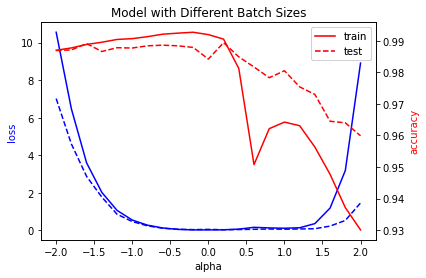

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alpha_list, TrainLossList, 'b', label='train')
ax1.plot(alpha_list, TestLossList, 'b--', label='test')
ax2.plot(alpha_list, TrainAccList, 'r', label='train')
ax2.plot(alpha_list, TestAccList, 'r--', label='test')
ax1.set_xlabel('alpha')
ax1.set_ylabel('loss', color='b')
ax2.set_ylabel('accuracy', color='r')
ax1.legend()
ax2.legend(loc='upper right')
ax1.set_title('Model with Different Batch Sizes')
fig.savefig('batchsizehw13.png')

# Models with different learning rates

In [20]:
epoch = 5
m1_lr = CNN()
print("==============Model_1: Learning Rate= 1e-2==============")
trainloss1, trainacc1, m1_lr = train(m1_lr, lr=1e-2, epoch=epoch, batch_size=128)

m2_lr = CNN()
print("\n==============Model_2: Learning Rate = 1e-3==============")
trainloss2, trainacc2, m2_lr = train(m2_lr, lr=1e-3, epoch=epoch, batch_size=128)

==============Model_1: Learning Rate = 1e-2==============
Epoch: 1  Train Loss: 0.3622  Train Accuracy 0.88
Epoch: 2  Train Loss: 0.0977  Train Accuracy 0.97
Epoch: 3  Train Loss: 0.0739  Train Accuracy 0.98
Epoch: 4  Train Loss: 0.0691  Train Accuracy 0.98
Epoch: 5  Train Loss: 0.0672  Train Accuracy 0.98

==============Model_2: Learning Rate = 1e-3==============
Epoch: 1  Train Loss: 0.4934  Train Accuracy 0.83
Epoch: 2  Train Loss: 0.0946  Train Accuracy 0.97
Epoch: 3  Train Loss: 0.0600  Train Accuracy 0.98
Epoch: 4  Train Loss: 0.0439  Train Accuracy 0.99
Epoch: 5  Train Loss: 0.0371  Train Accuracy 0.99


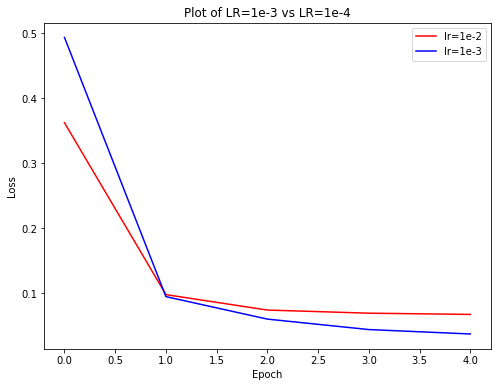

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(epoch), trainloss1, 'r', label='lr=1e-2')
plt.plot(np.arange(epoch), trainloss2, 'b', label='lr=1e-3')
plt.title("Plot of LR=1e-3 vs LR=1e-4")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model_lr1_params = torch.nn.utils.parameters_to_vector(m1_lr.parameters())
model_lr2_params = torch.nn.utils.parameters_to_vector(m2_lr.parameters())

In [30]:
alpha_list = np.arange(-2,2.2,0.2)
TrainLossList = []
TrainAccList = []
TestLossList = []
TestAccList = []

for i in range(len(alpha_list)):
    print(f'===================Alpha= {alpha_list[i]:.2f}===================')
    new_parameters = (1 - alpha_list[i])*model_lr1_params + alpha_list[i]*model_lr2_params
    new_model = CNN()
    torch.nn.utils.vector_to_parameters(new_parameters, new_model.parameters())
    trainloss, trainacc, new_model = train(new_model, lr=0.001, epoch=1, batch_size=128)
    TrainAccList.append(trainacc[-1].item())
    TrainLossList.append(min(trainloss))
    
    #test model
    testloss, testacc = validate(new_model)
    TestLossList.append(testloss[0])
    TestAccList.append(testacc[0].item())
    #print(f'Train Loss {min(trainloss)} Train Accuracy {trainacc[-1]} Test Loss {testloss} Test Accuracy {testacc}')

===================Alpha= -2.00===================
Epoch: 1  Train Loss: 47.4400  Train Accuracy 0.96
===================Alpha= -1.80===================
Epoch: 1  Train Loss: 26.5621  Train Accuracy 0.96
===================Alpha= -1.60===================
Epoch: 1  Train Loss: 14.0895  Train Accuracy 0.97
===================Alpha= -1.40===================
Epoch: 1  Train Loss: 7.4305  Train Accuracy 0.97
===================Alpha= -1.20===================
Epoch: 1  Train Loss: 3.7211  Train Accuracy 0.98
===================Alpha= -1.00===================
Epoch: 1  Train Loss: 1.7353  Train Accuracy 0.98
===================Alpha= -0.80===================
Epoch: 1  Train Loss: 0.7764  Train Accuracy 0.98
===================Alpha= -0.60===================
Epoch: 1  Train Loss: 0.2929  Train Accuracy 0.99
===================Alpha= -0.40===================
Epoch: 1  Train Loss: 0.1209  Train Accuracy 0.99
===================Alpha= -0.20===================
Epoch: 1  Train Loss: 0.0477  Train A

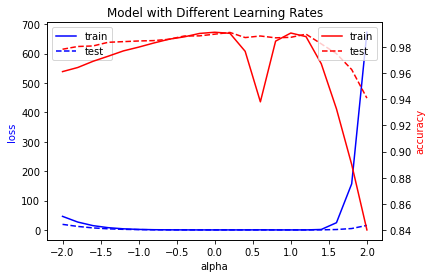

In [29]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alpha_list, TrainLossList, 'b', label='train')
ax1.plot(alpha_list, TestLossList, 'b--', label='test')
ax2.plot(alpha_list, TrainAccList, 'r', label='train')
ax2.plot(alpha_list, TestAccList, 'r--', label='test')
ax1.set_xlabel('alpha')
ax1.set_ylabel('loss', color='b')
ax2.set_ylabel('accuracy', color='r')
ax1.legend()
ax2.legend(loc='upper right')
ax1.set_title('Model with Different Learning Rates')
fig.savefig('learning_ratehw13.png')